In [1]:
import os
from pathlib import Path
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm
import logging
from datetime import datetime
from torchmetrics import MeanSquaredError

import matplotlib.pyplot as plt
import numpy as np
from AGG.utils import Time2Vec
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from AGG.extended_typing import collate_graph_samples
from Datasets.SparseSinusoid.datareader import SinusoidData, SinusoidDataset

import matplotlib
%matplotlib inline

In [2]:
save = False

In [3]:
sinusoid_data = SinusoidData(
    context_length=30,
    t_end=1000,
    fs=5,
    f=0.1,
    sparsity=0.60,
)

100%|██████████| 1970/1970 [00:04<00:00, 399.77it/s]


In [4]:

train_reader = SinusoidDataset(
    train=True,
    train_split=0.8,
    sinusoid_data=sinusoid_data
)
train_dataloader = DataLoader(
    train_reader,
    shuffle=True,
    batch_size=2000,
    drop_last=False,
    num_workers=0,
    collate_fn=collate_graph_samples,
    persistent_workers=False,
)
val_reader = SinusoidDataset(
    train=False,
    train_split=0.8,
    sinusoid_data=sinusoid_data
)
val_dataloader = DataLoader(
    val_reader,
    shuffle=False,
    batch_size=2000,
    drop_last=False,
    num_workers=0,
    collate_fn=collate_graph_samples,
    persistent_workers=False,
)

In [5]:
experiment = datetime.now().strftime("%d-%m_%H:%M:%S")
print(f'Log for {experiment=}')
dir_path = Path(f'./logs/{experiment}')
if save:
    dir_path.mkdir(parents=True, exist_ok=True)

Log for experiment='16-01_13:50:21'


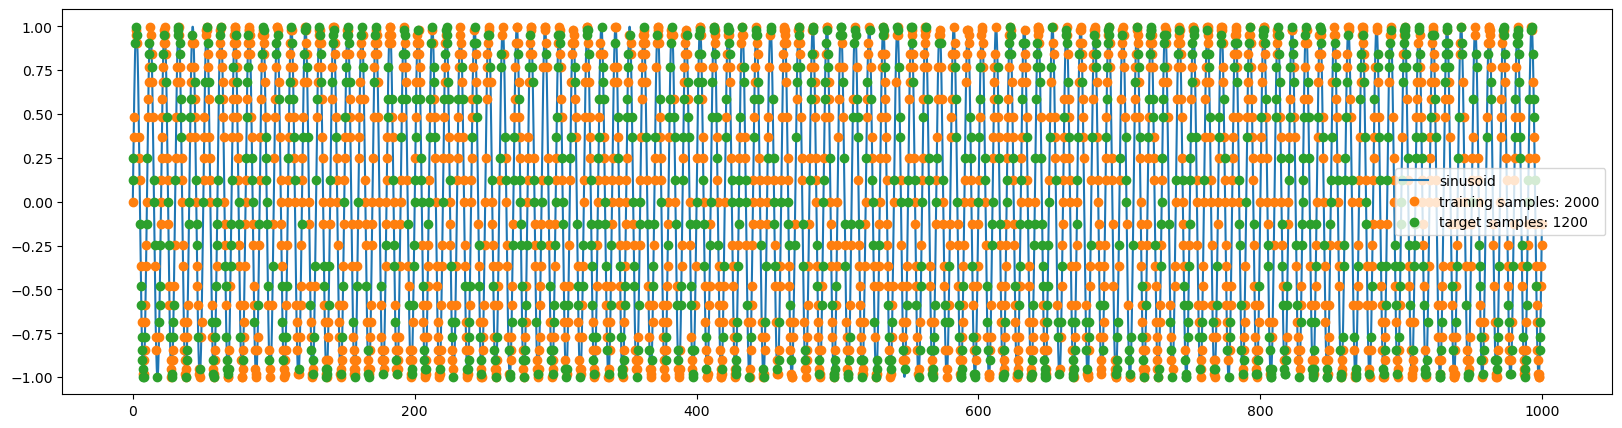

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(sinusoid_data.t, sinusoid_data.x, label='sinusoid')
plt.plot(sinusoid_data.training_samples_t, sinusoid_data.training_samples, 'o', label=f'training samples: {sinusoid_data.training_samples.shape[0]}')
plt.plot(sinusoid_data.target_samples_t, sinusoid_data.target_samples, 'o', label=f'target samples: {sinusoid_data.target_samples.shape[0]}')
plt.legend()
if save:
    plt.savefig(dir_path / 'data_samples.png')
plt.show()

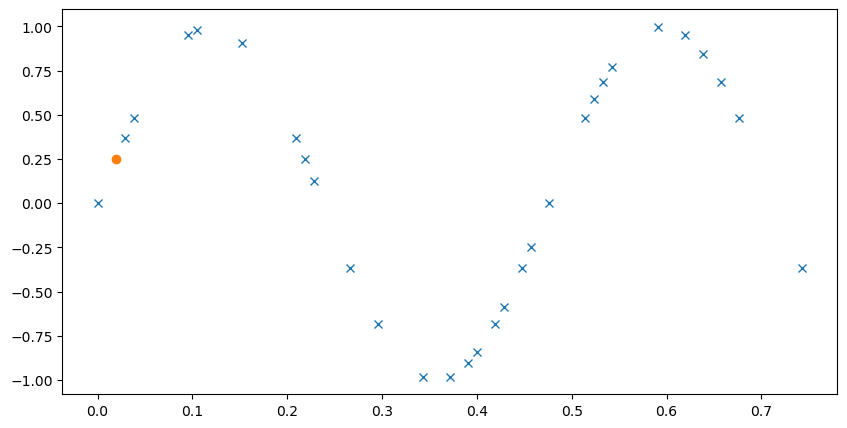

In [7]:
sample = train_reader[1]
plt.figure(figsize=(10, 5))
plt.plot(sample.time, sample.node_features, 'x', label='sinusoid')
plt.plot(sample.target.time, sample.target.features, 'o', label='target')

In [8]:
class GraphAttentionGenerator(nn.Module):
    def __init__(
            self,
            query_dim: int,
            key_dim: int,
            hidden_dim: int,
            num_heads: int = 2,
            dropout: float = 0.1,
            negative_slope: float = 0.2,
            is_concat: bool = True
    ):
        super(GraphAttentionGenerator, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.is_concat = is_concat
        self.dropout = nn.Dropout(dropout)

        if is_concat:
            assert hidden_dim % num_heads == 0
            self.hidden_dim = hidden_dim // num_heads
        else:
            self.hidden_dim = hidden_dim

        self.linear_query = nn.Linear(query_dim, self.hidden_dim * num_heads)
        self.node_projection = nn.Linear(key_dim, self.hidden_dim * num_heads)
        self.attention = nn.Linear(self.hidden_dim, 1, bias=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)
        self.non_linearity = nn.ReLU()
        
    def forward(self, query, key):
        # key: [batch_size, num_nodes, key_dim]
        # value: [batch_size, num_nodes, value_dim]
        batch_size, num_nodes, _ = key.shape
        if len(query.shape) != 3:
            # query: [batch_size, query_dim]
            query = query.unsqueeze(1)
        # query: [batch_size, num_nodes, query_dim]
        h_query = self.linear_query(query)
        # h_query: [batch_size, num_nodes, hidden_dim]

        # Create Heads
        h_query = h_query.view(batch_size, 1, self.num_heads, self.hidden_dim)
        # h_query: [batch_size, 1, num_heads, hidden_dim]
        h_key = self.node_projection(key).view(batch_size, num_nodes, self.num_heads, self.hidden_dim)
        # h_key: [batch_size, num_nodes, num_heads, hidden_dim]

        # Duplicate query
        h_query = h_query.repeat(1, num_nodes, 1, 1)
        # h_query: [batch_size, num_nodes, num_heads, hidden_dim]

        # Add query and key
        h = h_query + h_key
        # h: [batch_size, num_nodes, num_heads, hidden_dim]

        e = self.leaky_relu(h)
        e = self.attention(e)
        # e: [batch_size, num_nodes, num_heads, 1]
        e = e.squeeze(-1)
        # e: [batch_size, num_nodes, num_heads]
        e = self.dropout(e)
        e = torch.softmax(e, dim=1)
        # e: [batch_size, num_nodes, num_heads]
        scored_nodes = torch.einsum("bjh,bjhf->bhf", e, h_key)
        # scored_value: [batch_size, num_heads, hidden_dim]
        if self.is_concat:
            scored_nodes = scored_nodes.reshape(batch_size, -1)
        else:
            scored_nodes = torch.mean(scored_nodes, dim=1)
        h_prime = self.non_linearity(scored_nodes)
        return h_prime, e
        

In [9]:
class GraphAttentionLayer(nn.Module):
    def __init__(
            self,
            query_dim: int,
            key_dim: int,
            hidden_dim: int,
            num_heads: int = 2,
            dropout: float = 0.1,
            negative_slope: float = 0.2,
            is_concat: bool = True,
            share_weights: bool = True
    ):
        super(GraphAttentionLayer, self).__init__()
        self.query_dim = query_dim
        self.key_dim = key_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.is_concat = is_concat
        self.dropout = nn.Dropout(dropout)

        if is_concat:
            assert hidden_dim % num_heads == 0
            self.hidden_dim = hidden_dim // num_heads
        else:
            self.hidden_dim = hidden_dim

        self.query_projection = nn.Linear(query_dim, self.hidden_dim * num_heads)
        if share_weights:
            self.key_projection = self.query_projection
        else:
            self.key_projection = nn.Linear(key_dim, self.hidden_dim * num_heads)
        self.attention = nn.Linear(self.hidden_dim, 1, bias=False)
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)
        self.non_linearity = nn.ReLU()
        
    def forward(self, query, key):
        # key: [batch_size, num_nodes, key_dim]
        batch_size, num_nodes, _ = key.shape
        # query: [batch_size, num_nodes, query_dim]
        h_query = self.query_projection(query)
        # h_query: [batch_size, num_nodes, hidden_dim]
        h_key = self.key_projection(key)
        # h_key: [batch_size, num_nodes, hidden_dim]

        # Create Heads
        h_query = h_query.view(batch_size, num_nodes, self.num_heads, self.hidden_dim)
        # h_query: [batch_size, num_nodes, num_heads, hidden_dim]
        h_key = h_key.view(batch_size, num_nodes, self.num_heads, self.hidden_dim)
        # h_key: [batch_size, num_nodes, num_heads, hidden_dim]

        # Duplicate query
        h_query_repeated = h_query.repeat(1, num_nodes, 1, 1)
        # h_query: [batch_size, num_nodes*num_nodes, num_heads, hidden_dim]
        # Duplicate key
        h_key_repeated = h_key.repeat_interleave(num_nodes, dim=1)
        # h_key: [batch_size, num_nodes*num_nodes, num_heads, hidden_dim]
        
        # Add query and key
        h = h_query_repeated + h_key_repeated
        # h: [batch_size, num_nodes*num_nodes, num_heads, hidden_dim]
        h = h.view(batch_size, num_nodes, num_nodes, self.num_heads, self.hidden_dim)
        # h: [batch_size, num_nodes, num_nodes, num_heads, hidden_dim]
        
        e = self.leaky_relu(h)
        e = self.attention(e)
        # e: [batch_size, num_nodes, num_nodes, num_heads, 1]
        e = e.squeeze(-1)
        # e: [batch_size, num_nodes, num_nodes, num_heads]
        e = torch.softmax(e, dim=2)
        e = self.dropout(e)
        # e: [batch_size, num_nodes, num_nodes, num_heads]
        scored_nodes = torch.einsum("bijh,bjhf->bihf", e, h_key)
        # scored_value: [batch_size, num_nodes, num_heads, hidden_dim]
        if self.is_concat:
            scored_nodes = scored_nodes.reshape(batch_size, num_nodes, -1)
        else:
            scored_nodes = torch.mean(scored_nodes, dim=2)
        h_prime = self.non_linearity(scored_nodes)
        return h_prime, e

In [10]:
class AGG(nn.Module):
    def __init__(
            self, 
            time_embed_dim: int, 
            feature_dim: int, 
            hidden_dim: int, 
            num_heads: int,
            out_dim: int, 
            dropout: float = 0.1, 
            negative_slope: float = 0.2,
            include_linear: bool = True
    ):  
        super(AGG, self).__init__()
        self.time2vec = Time2Vec(time_embed_dim, include_linear=include_linear)
        self.key_dim = feature_dim + time_embed_dim
        self.value_dim = feature_dim + time_embed_dim
        
        self.graph_attention_layer = GraphAttentionLayer(
            query_dim=self.key_dim, 
            key_dim=self.key_dim, 
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout, 
            negative_slope=negative_slope,
            is_concat=True,
            share_weights=True
        )
        
        self.graph_attention_generator = GraphAttentionGenerator(
            query_dim=time_embed_dim, 
            key_dim=hidden_dim, 
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout, 
            negative_slope=negative_slope
        )
        self.prediction = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, key_value, key_time, query_time, device: str = 'cpu'):
        key_value = key_value.unsqueeze(-1).to(device)
        key_time = key_time.unsqueeze(-1).to(device)
        query_time = query_time.unsqueeze(-1).to(device)
        
        # Time embedding for query and key
        query = self.time2vec(query_time)
        tau = self.time2vec(key_time)
        
        # Concatenate node_features and time embeddings
        key = torch.cat([key_value, tau], dim=-1)
        
        # Generate graph attention layer
        h_prime, graph_attention = self.graph_attention_layer(key, key)
        # h_prime = self.feed_forward(h_prime)
        
        # Generate conditional node
        h_prime, graph_attention = self.graph_attention_generator(query, h_prime)
        y = self.prediction(h_prime)
        return y, graph_attention

In [11]:
model = AGG(
    time_embed_dim=8, 
    feature_dim=1, 
    hidden_dim=32, 
    num_heads=4,
    out_dim=1, 
    dropout=0.1, 
    negative_slope=0.2,
    include_linear=True
)

LOG = logging.getLogger(__name__)

logging.basicConfig(level=logging.INFO)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

print(f"Number of training samples: {len(train_reader)}")
print(f"Model summary: {model}")
model = model.to(device)

Using device cuda:0
Number of training samples: 27376
Model summary: AGG(
  (time2vec): Time2Vec(
    (scale): FrequencyScale(
      (unscaled_bias): Parameter(in_features=8)
      (linear): Linear(in_features=1, out_features=8, bias=False)
    )
  )
  (graph_attention_layer): GraphAttentionLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (query_projection): Linear(in_features=9, out_features=32, bias=True)
    (key_projection): Linear(in_features=9, out_features=32, bias=True)
    (attention): Linear(in_features=8, out_features=1, bias=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (non_linearity): ReLU()
  )
  (graph_attention_generator): GraphAttentionGenerator(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear_query): Linear(in_features=8, out_features=32, bias=True)
    (node_projection): Linear(in_features=32, out_features=32, bias=True)
    (attention): Linear(in_features=8, out_features=1, bias=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
   

In [12]:
model = model.to(device)
mse_loss = nn.MSELoss()

train_RMSE = MeanSquaredError(squared=False).to(device)
val_RMSE = MeanSquaredError(squared=False).to(device)
epochs = 4000
max_lr = 0.001
min_lr = 0.0001
warm_up = 1000
T_max = 500

optimiser = torch.optim.Adam(model.parameters(), lr=max_lr)

total_train = np.inf
total_val = np.inf
lowest_loss = np.inf

lr_schedule = [max_lr]
train_loss_plot = []
val_loss_plot = []
val_RMSE_plot = []
train_RMSE_plot = []
t2v_weights = []
t2v_bias = []

with logging_redirect_tqdm():
    prog_bar = trange(epochs, leave=True)
    for epoch in prog_bar:
        model.train()
        for graph_samples in train_dataloader:
            y_hat, total_attention = model(graph_samples.node_features, graph_samples.time, graph_samples.target.time, device=device)
            loss = mse_loss(y_hat, graph_samples.target.features.to(device))
            train_loss_plot.append(loss.item())
            t2v_weights.append(model.time2vec.scale.weight.detach().cpu().tolist())
            t2v_bias.append(model.time2vec.scale.bias.detach().cpu().tolist())
            rmse = train_RMSE(y_hat, graph_samples.target.features.to(device))
            optimiser.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimiser.step()
            prog_bar.set_description(
                f"current loss: {loss.item()}, lr:{lr_schedule[-1]}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}", refresh=True)

        with torch.no_grad():
            total_train = train_RMSE.compute()
            train_RMSE_plot.append(total_train.item())
            train_RMSE.reset()
            prog_bar.set_description(
                f"current loss: {loss.item()}, lr:{lr_schedule[-1]}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}", refresh=True)
            model.eval()
            loss_total = 0
            for graph_samples in val_dataloader:
                y_hat, total_attention = model(graph_samples.node_features, graph_samples.time, graph_samples.target.time, device=device)
                loss = mse_loss(y_hat, graph_samples.target.features.to(device))
                val_loss_plot.append(loss.item())
                loss_total += loss.item()
                rmse = val_RMSE(y_hat, graph_samples.target.features.to(device))
            total_val = val_RMSE.compute()
            val_RMSE.reset()
            val_RMSE_plot.append(total_val.item())
            prog_bar.set_description(
                f"current loss: {loss.item()}, lr:{lr_schedule[-1]}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}",
                refresh=True)
            if loss_total < lowest_loss:
                if save:
                    torch.save(
                        model.state_dict(), dir_path / f"best_GAT_model_{experiment}.mdl"
                    )
                    lowest_loss = total_val

current loss: 0.019752420485019684, lr:0.001, train_rmse 0.0774, val_rmse 0.1523: 100%|██████████| 4000/4000 [31:02<00:00,  2.15it/s] 


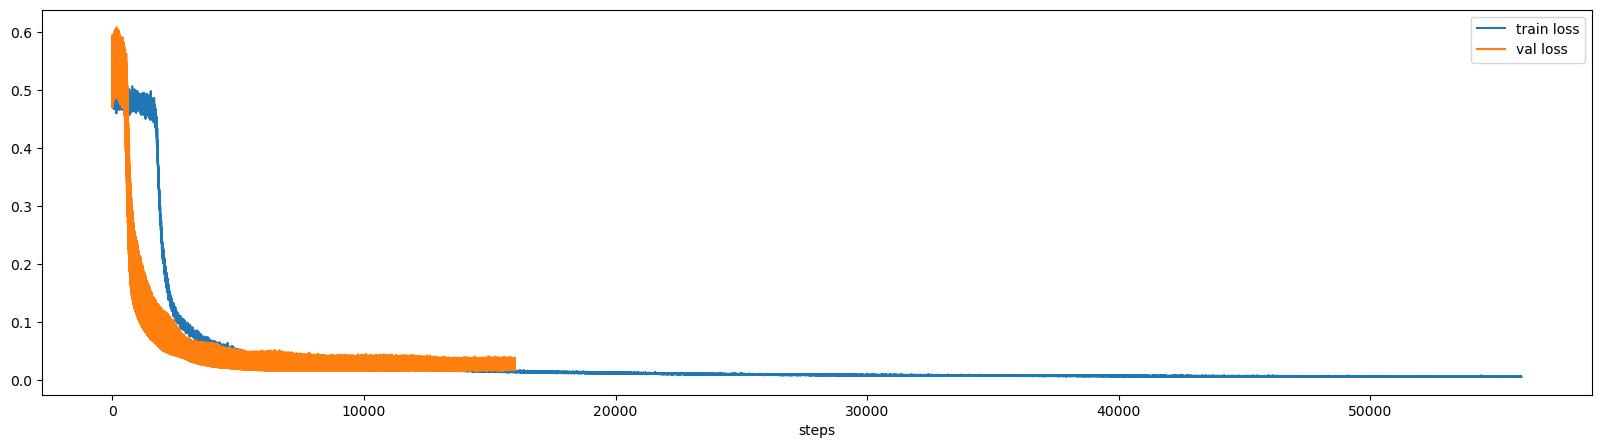

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(train_loss_plot, label='train loss')
plt.plot(val_loss_plot, label='val loss')
plt.xlabel('steps')
plt.legend()
plt.show()

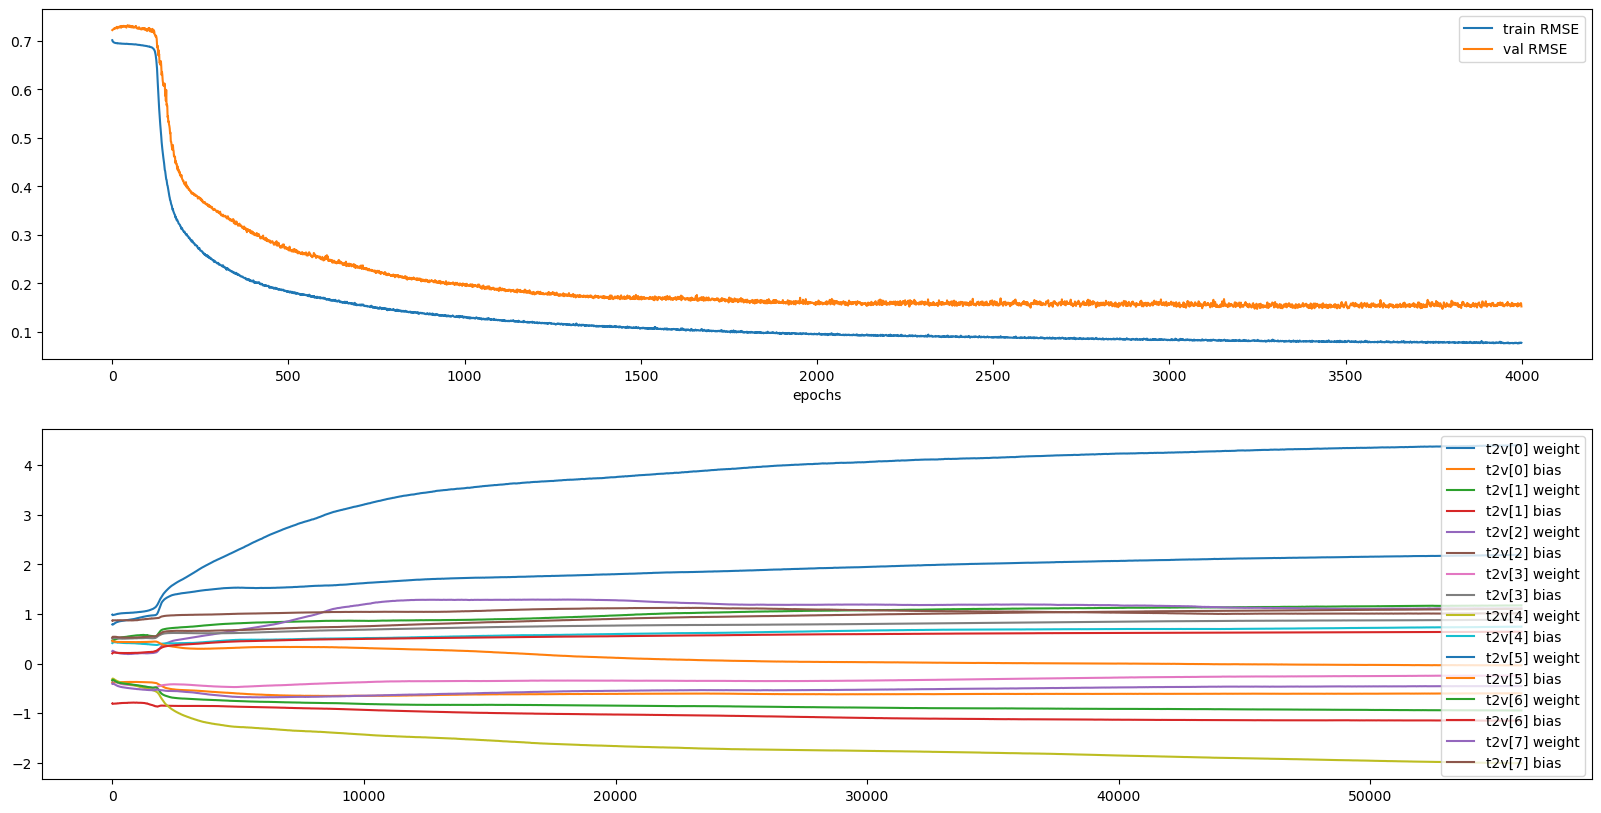

In [14]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(train_RMSE_plot, label='train RMSE')
plt.plot(val_RMSE_plot, label='val RMSE')
plt.xlabel('epochs')
plt.legend()
plt.subplot(2, 1, 2)
t2v_weights = np.array(t2v_weights)
t2v_bias = np.array(t2v_bias)
for i in range(t2v_weights.shape[1]):
    plt.plot(t2v_weights[:, i], label=f't2v[{i}] weight')
    plt.plot(t2v_bias[:, i], label=f't2v[{i}] bias')
plt.legend()
plt.show()

In [15]:
tau_query = torch.linspace(0, 1, 1000)
tau_query.shape

torch.Size([1000])

In [16]:
sample = 300
node_t = val_reader.data_samples[sample].time.repeat(1000, 1)
node = val_reader.data_samples[sample].node_features.repeat(1000, 1)

In [17]:
node.shape

torch.Size([1000, 30])

In [18]:
model.eval()
with torch.no_grad():
    y_hat, total_attention = model(node, node_t, tau_query, device=device)
    y_hat = y_hat.cpu().numpy()
    total_attention = total_attention.cpu().numpy()

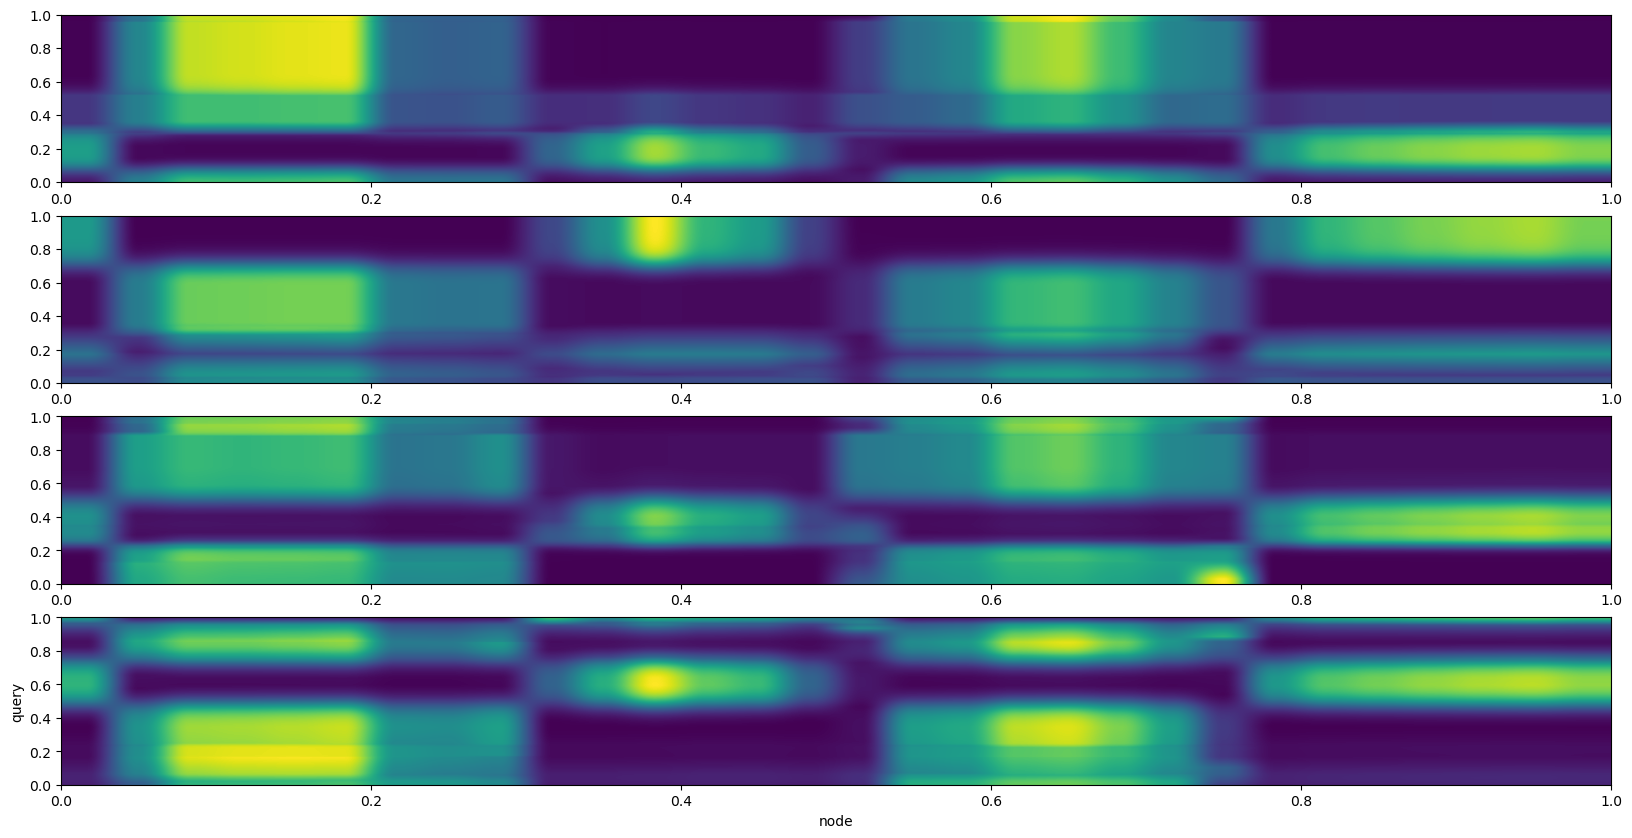

In [19]:
heads = total_attention.shape[2]
fig, ax = plt.subplots(heads, 1, figsize=(20, 10))
for i in range(heads):
    ax[i].imshow(total_attention[:, :, i], extent=[0, 1, 0, 1], cmap='viridis')
    ax[i].axis('tight')
plt.xlabel("node")
plt.ylabel("query")
plt.show()

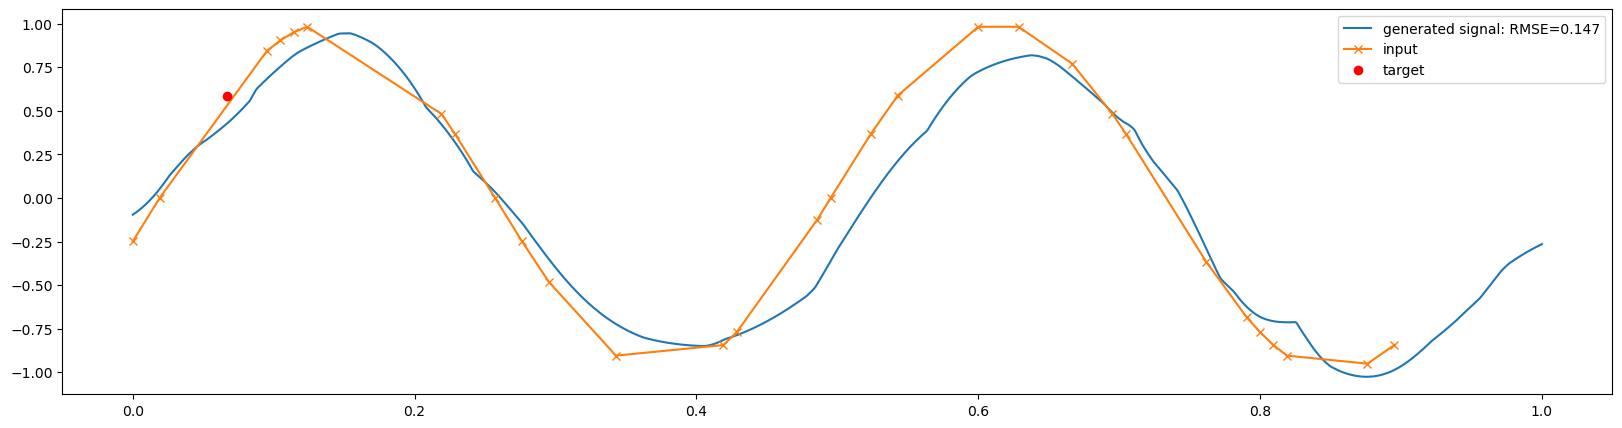

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(tau_query, y_hat, label=f'generated signal: RMSE={min(val_RMSE_plot):.3f}')
# plt.plot(sinusoid_data.t/sinusoid_data.t.max(), sinusoid_data.x, label='ground truth signal')
plt.plot(val_reader.data_samples[sample].time.flatten().numpy(), 
         val_reader.data_samples[sample].node_features.flatten().numpy(), '-x', label=f'input')
plt.plot(val_reader.data_samples[sample].target.time.flatten().numpy(), 
         val_reader.data_samples[sample].target.features.flatten().numpy(), 'ro', label=f'target')
plt.legend()
plt.show()